The [SPAM](https://www.kaggle.com/uciml/sms-spam-collection-dataset) dataset contains 5572 SMS messages and a label. Using this dataset, you are going to create a machine learning model that learns to detect "spam" or not "spam".

## Imports Libraries

In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import wordcloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# SIMPLE EDA

In [2]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The Columns 2,3,4 will be dropped as they contain no relevant information

In [3]:
data = df.copy()
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [4]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Distribution of the label variable

The dataset contains 4825 ham and 747 spam messages.  

In [5]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

/Users/mac/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


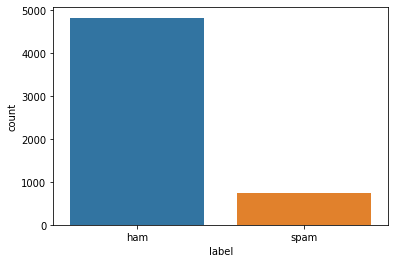

In [6]:
sns.countplot(data['label'])
plt.show()

Convert labels numerical format

In [7]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## FEATURE ENGINEERING AND PREPROCESSING

In [8]:
##add the length of the text as a feature
data['text_length'] = data['text'].apply(len)

In [9]:
data.head(10)

,label,text,text_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


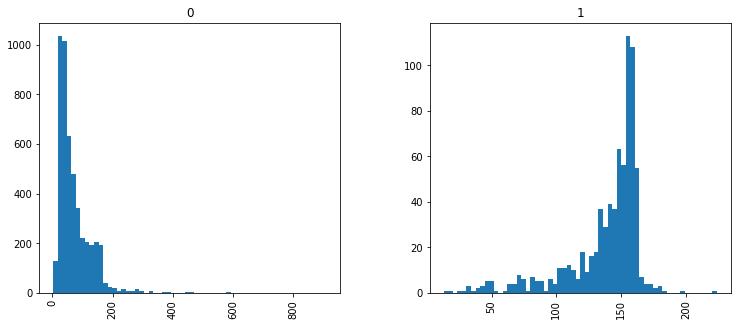

In [10]:
data.hist(column='text_length',by='label',bins=60,figsize=(12,5));
# plt.xlim(-40,950);

Spam(1) messages are generally longer than ham (0) messages:  
Majority of ham has length below 100, for spam it is above 100. This extra feature (text_length) may prove useful to our model.  

In [11]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

WordClouds

In [12]:
def show_wordcloud(text, title):
    text = ' '.join(text['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

### WordCloud: Ham messages

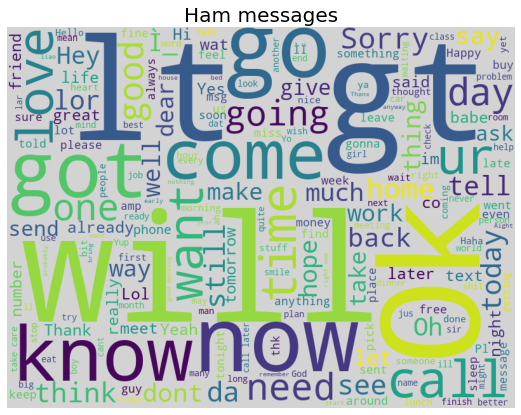

In [13]:
show_wordcloud(data_ham, "Ham messages")

### WordCloud: Spam messages

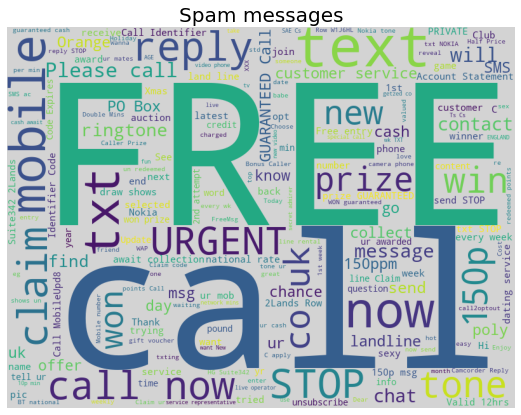

In [14]:
show_wordcloud(data_spam, "Spam messages")

Notice that majority of the word in Spam messages contains terms like FREE, CALL, URGENT. These terms will serve as important features to our model. 

Next, we'll do some NLP preprocessing task in the order shown below:

* Puntuation and stopword removal
* Tokenization
* Vectorization and 
* TF-IDF weighting  

### Punctuation
**We use the punctuation list from the string library:**

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
from nltk.corpus import stopwords
stopwords.words("english")[0:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

**With the above lists for punctuation characters and stop words, we define a function to remove these from the text**  
**This function also converts all text to lowercase**

In [17]:
def remove_punctuation_and_stopwords(text):
    
    clean_txt = [ch for ch in text if ch not in string.punctuation]
    clean_txt = "".join(clean_txt).split()
    
    clean_txt = [word.lower() for word in clean_txt if word.lower() not in stopwords.words("english")]
        
    return clean_txt

In [18]:
data['text'].apply(remove_punctuation_and_stopwords)

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, u, å£750, po...
5568                   [ì, b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: text, Length: 5572, dtype: object

In [19]:
from sklearn.model_selection import train_test_split

X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [64]:
# pad documents to a max length of 4 words
max_length = 5
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)

[[  18  299   30  349 1990]
 [   9    4  203 1025  225]
 [ 672  350    2 3794 3795]
 ...
 [1051  685  239   30 2064]
 [ 763 1679 1161    1  255]
 [  72   17    8  290  175]]


In [65]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 24)             190920    
_________________________________________________________________
flatten_3 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               60500     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [55]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train, 
          y=y_train, 
          epochs=20,
          validation_data=(padded_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/20
140/140 [==============================] - 0s 3ms/step - loss: 0.1905 - accuracy: 0.9275 - val_loss: 0.1019 - val_accuracy: 0.9740
Epoch 2/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.9850 - val_loss: 0.0803 - val_accuracy: 0.9803
Epoch 3/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0961 - val_accuracy: 0.9821
Epoch 4/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.1451 - val_accuracy: 0.9821
Epoch 5/20
140/140 [==============================] - 0s 3ms/step - loss: 5.5071e-04 - accuracy: 0.9998 - val_loss: 0.1885 - val_accuracy: 0.9839
Epoch 6/20
140/140 [==============================] - 0s 2ms/step - loss: 3.3032e-06 - accuracy: 1.0000 - val_loss: 0.2326 - val_accuracy: 0.9830
Epoch 7/20
140/140 [==============================] - 0s 2ms/step - loss: 1.9503e-08 - accuracy: 1.0000 - val_loss: 0.2634 - val_accuracy: 0

In [56]:
# evaluate the model
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 98.295963


In [61]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [62]:
def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    return acc_sc


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.90      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9829596412556054


0.9829596412556054

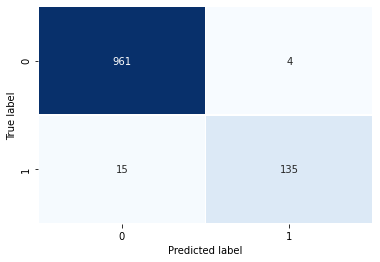

In [63]:
plot_confusion_matrix(y_test, preds)

## SAVING MODEL AND TOKENIZER

In [37]:
model.save("spam_model")

INFO:tensorflow:Assets written to: spam_model/assets


In [45]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
    pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

## LOADING AND EVALUATING MODEL

In [39]:
s_model = tf.keras.models.load_model("spam_model")

with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokener = pickle.load(input)
 
s_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 16)            127280    
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               120500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 368,181
Trainable params: 368,181
Non-trainable params: 0
__________________________________________________

In [40]:
sms = [X_test[2]]
print(sms)
print(y_test[1], y_test[2])

sms_proc = tokener.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')

['We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p']
0 1


In [44]:
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
pred

1